In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# Load Model and tokenizers
tokenizer = AutoTokenizer.from_pretrained("yash3056/Llama-3.2-1B-imdb")
model = AutoModelForSequenceClassification.from_pretrained("yash3056/Llama-3.2-1B-imdb", num_labels=2) #n is the number of labels in the code
model.model.config._attn_implementation = "sdpa"

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [4]:
from lrp_engine import LRPEngine, checkpoint_hook

In [5]:
for layer in model.model.layers:
    layer.self_attn.o_proj.register_forward_hook(checkpoint_hook)

In [6]:
model.to(device)

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128001)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((20

In [7]:
import os
# Download from here: https://ai.stanford.edu/~amaas/data/sentiment/
filepath1 = "../../external/aclImdb/test/pos/"
filepath2 = "../../external/aclImdb/test/neg/"
filenames1 = os.listdir(filepath1)[:100]
filenames2 = os.listdir(filepath2)[:100]

In [8]:
# Read the examples in and prepare them for model input + LRP
pos_reviews = []
neg_reviews = []
for filename in filenames1:
    with open(filepath1 + filename, "r") as fileIn:
        line = fileIn.readline().strip()
        pos_reviews.append(line)
for filename in filenames2:
    with open(filepath2 + filename, "r") as fileIn:
        line = fileIn.readline().strip()
        neg_reviews.append(line)
print(len(pos_reviews), len(neg_reviews))
all_inputs = sorted([ tokenizer(x, return_tensors = 'pt', max_length=256, truncation=True)["input_ids"] for x in pos_reviews + neg_reviews ], key=lambda t: t.shape[-1], reverse=True)


100 100


In [9]:
outputs : torch.Tensor = model(all_inputs[0].to(device))

In [10]:
lrp_engine = LRPEngine()

In [11]:
# Run first pass
relevance_outputs = lrp_engine.run(outputs.logits)

In [12]:
# Run a second pass on same output to ensure consistency
relevance_outputs1 = lrp_engine.run(outputs.logits)

In [13]:
# Check results diff between 1st pass and 2nd pass on same input (should be ~0)
checkpoint_vals = relevance_outputs[0]
checkpoint_vals1 = relevance_outputs1[0]
embedding_vals = relevance_outputs[1]
embedding_vals1 = relevance_outputs1[1]
[
    ((c1 - c2)**2).sum()
    for (c1, c2) in zip(checkpoint_vals + embedding_vals, checkpoint_vals1 + embedding_vals1)
]

[tensor(1.5684e-12, device='cuda:0'),
 tensor(7.2489e-13, device='cuda:0'),
 tensor(4.5564e-13, device='cuda:0'),
 tensor(6.9959e-12, device='cuda:0'),
 tensor(2.1261e-11, device='cuda:0'),
 tensor(2.9065e-11, device='cuda:0'),
 tensor(9.0140e-12, device='cuda:0'),
 tensor(1.5820e-14, device='cuda:0'),
 tensor(6.1283e-14, device='cuda:0'),
 tensor(3.5850e-15, device='cuda:0'),
 tensor(8.1557e-16, device='cuda:0'),
 tensor(2.7549e-14, device='cuda:0'),
 tensor(1.2616e-14, device='cuda:0'),
 tensor(8.4493e-15, device='cuda:0'),
 tensor(1.0458e-15, device='cuda:0'),
 tensor(1.1822e-15, device='cuda:0'),
 tensor(3.3033e-13, device='cuda:0')]

In [14]:
from util import accumulate_variable_matrix, visualize_attention_layer_relevance

In [15]:
from tqdm import tqdm
all_reviews = neg_reviews + pos_reviews
embedding_vals = []
input_idxs = []
preds = []
agg_checkpoint_vals = None
for i in tqdm(range(200)):
    inputs = tokenizer(all_reviews[i], return_tensors = 'pt', max_length=128, truncation=True)["input_ids"]
    outputs : torch.Tensor = model(inputs.to(device))
    relevance_outputs = lrp_engine.run(outputs.logits)

    checkpoint_vals = relevance_outputs[0]
    checkpoint_vals = [ c.squeeze(0) if c.dim() == 3 else c for c in checkpoint_vals ]
    embedding_vals.append(relevance_outputs[1])
    input_idxs.append(inputs)
    preds.append(outputs.logits.detach())
    
    if agg_checkpoint_vals is None:
        agg_checkpoint_vals = checkpoint_vals
    else:
        for j in range(len(agg_checkpoint_vals)):
            accumulate_variable_matrix(agg_checkpoint_vals[j], checkpoint_vals[j])
            # agg_checkpoint_vals[j] += checkpoint_vals[j]

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.83it/s]


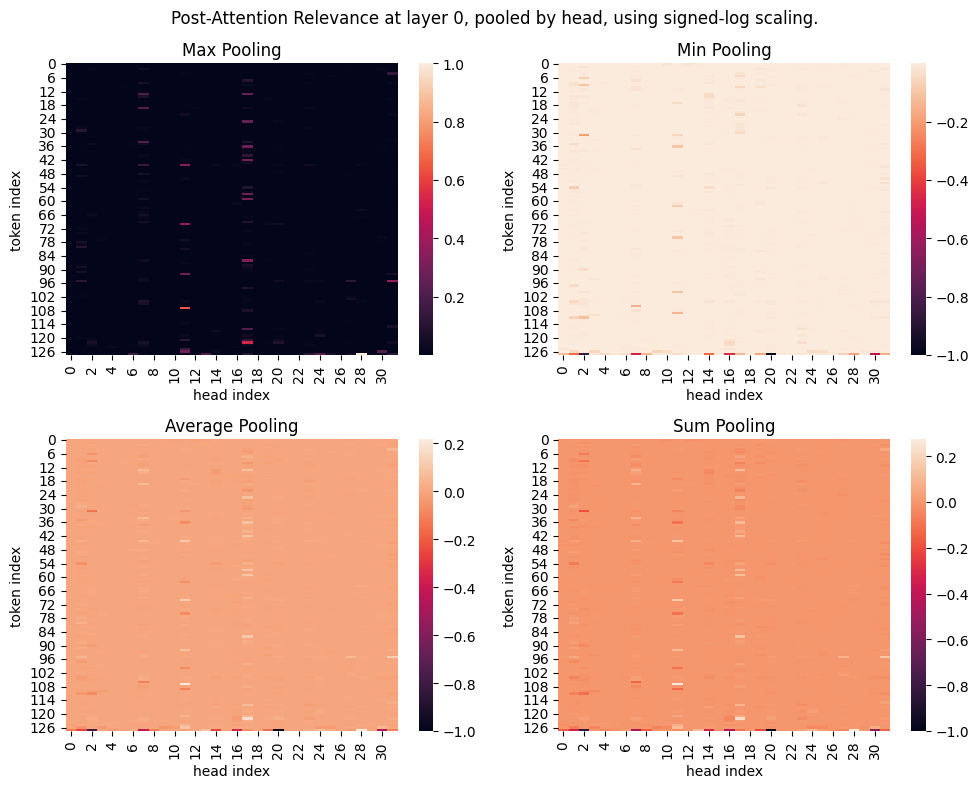

In [16]:
visualize_attention_layer_relevance(agg_checkpoint_vals, layer_ind=0)

 obstacle only closety closet His aOnce in of clutter signs
tensor([[-0.7841, -6.9002]], device='cuda:0')
Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an ho

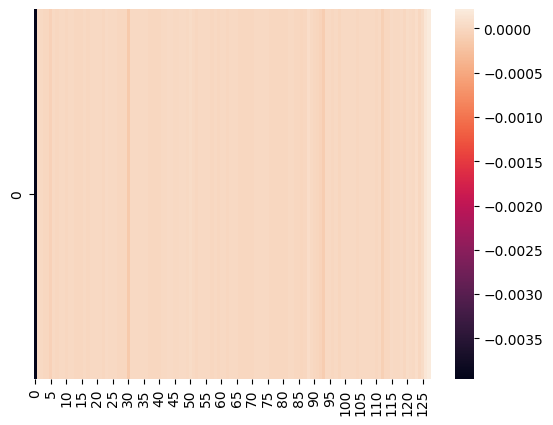

In [20]:
example_ind = 0
sns.heatmap(embedding_vals[example_ind][0].cpu())
print(tokenizer.decode(input_idxs[example_ind][0][embedding_vals[example_ind][0].cpu().flatten().topk(12).indices]))
print(preds[example_ind])
print(all_reviews[example_ind])
